In [1]:
!pip install git+https://github.com/forrestbao/pyeeg.git

import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
import pyeeg as pe
import pickle as pickle
import math
from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-s5k89y_4
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-s5k89y_4
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28123 sha256=7a0e41f64fe053fb7f1fd8101414242d867b84ad1d3c9433760e96866b046b9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-rpftypat/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D,Conv1D
from keras.models import Sequential
from keras.utils import to_categorical 

from keras.models import Model
import timeit
from keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Getting data 

In [4]:
with open('/content/drive/MyDrive/Colab Notebooks/DEAP  - saved/data_training.npy', 'rb') as fileX_training:
    X_train  = np.load(fileX_training)
    
with open('/content/drive/MyDrive/Colab Notebooks/DEAP  - saved/label_training.npy', 'rb') as fileY_training:
    Y_train  = np.load(fileY_training)   

In [8]:
X_train = normalize(X_train)
Z_train = np.ravel(Y_train[:, [1]])  # valence
#labels
train_arousal = np.ravel(Y_train[:, [0]])
train_valence = np.ravel(Y_train[:, [1]])
train_dominance = np.ravel(Y_train[:, [2]])
train_liking = np.ravel(Y_train[:, [3]])

In [9]:
from keras.utils import to_categorical
y_train = to_categorical(Z_train)
x_train = np.array(X_train[:])

In [10]:

with open('/content/drive/MyDrive/Colab Notebooks/DEAP  - saved/data_testing.npy', 'rb') as fileX_training:
    X_test  = np.load(fileX_training)
    
with open('/content/drive/MyDrive/Colab Notebooks/DEAP  - saved/label_testing.npy', 'rb') as fileY_training:
    Y_test  = np.load(fileY_training)


In [11]:
X_test = normalize(X_test)
Z_test = np.ravel(Y_test[:, [1]])  # valence

test_arousal = np.ravel(Y_test[:, [0]])
test_valence = np.ravel(Y_test[:, [1]])
test_dominance = np.ravel(Y_test[:, [2]])
test_liking = np.ravel(Y_test[:, [3]])

In [12]:
x_test = np.array(X_test[:])

In [13]:
from keras.utils import to_categorical
y_test = to_categorical(Z_test)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [14]:
from sklearn.preprocessing import StandardScaler
temp = StandardScaler()
x_train = temp.fit_transform(x_train)
x_test = temp.fit_transform(x_test)

# CNN1D Model

In [15]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
x_train.shape
classes = 10

input_shape=(x_train.shape[1], 1)
print(input_shape)

from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2

model_CNN1d = Sequential()
intput_shape=(x_train.shape[1], 1)
model_CNN1d.add(Conv1D(256, kernel_size=3,padding = 'same',activation='relu', input_shape=input_shape))
model_CNN1d.add(BatchNormalization())
model_CNN1d.add(MaxPooling1D(pool_size=(2)))
model_CNN1d.add(Conv1D(128,kernel_size=3,padding = 'same', activation='relu'))
model_CNN1d.add(BatchNormalization())
model_CNN1d.add(MaxPooling1D(pool_size=(2)))
model_CNN1d.add(Conv1D(64,kernel_size=3,padding = 'same', activation='relu'))
model_CNN1d.add(MaxPooling1D(pool_size=(2)))
model_CNN1d.add(Flatten())
model_CNN1d.add(Dense(64, activation='relu'))
model_CNN1d.add(Dropout(0.5))
model_CNN1d.add(Dense(32, activation='relu'))
model_CNN1d.add(Dropout(0.4))
model_CNN1d.add(Dense(16, activation='relu'))
model_CNN1d.add(Dropout(0.2))
model_CNN1d.add(Dense(classes, activation='softmax'))
model_CNN1d.summary()



(70, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 70, 256)           1024      
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 256)           1024      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 35, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           98432     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 17, 64)     

In [16]:
model_CNN1d.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])



# Training and Testing Model

In [17]:
iter = 100

In [18]:

grpah_model=model_CNN1d.fit(x_train, y_train,batch_size=256,epochs=iter,  verbose=1,validation_data=(x_test,y_test))

Epoch 1/100
179/179 [==============================] - 53s 287ms/step - loss: 2.2106 - accuracy: 0.1741 - val_loss: 2.1284 - val_accuracy: 0.1707
Epoch 2/100
179/179 [==============================] - 51s 282ms/step - loss: 2.0413 - accuracy: 0.2418 - val_loss: 2.0199 - val_accuracy: 0.2763
Epoch 3/100
179/179 [==============================] - 51s 283ms/step - loss: 1.9939 - accuracy: 0.2462 - val_loss: 1.9295 - val_accuracy: 0.2821
Epoch 4/100
179/179 [==============================] - 50s 282ms/step - loss: 1.9439 - accuracy: 0.2593 - val_loss: 1.8663 - val_accuracy: 0.2928
Epoch 5/100
179/179 [==============================] - 50s 282ms/step - loss: 1.9205 - accuracy: 0.2596 - val_loss: 1.8383 - val_accuracy: 0.2960
Epoch 6/100
179/179 [==============================] - 51s 283ms/step - loss: 1.8964 - accuracy: 0.2728 - val_loss: 1.8217 - val_accuracy: 0.3080
Epoch 7/100
179/179 [==============================] - 51s 286ms/step - loss: 1.8741 - accuracy: 0.2786 - val_loss: 1.8013 -

In [19]:
score = model_CNN1d.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

357/357 [==============================] - 4s 10ms/step - loss: 1.1442 - accuracy: 0.6226
Test loss: 1.1442205905914307
Test accuracy: 0.6226249933242798


# Plots

In [20]:
# list all data in history
print(grpah_model.history.keys())
import matplotlib.pyplot as plt
import numpy


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Epochs vs Accuracy

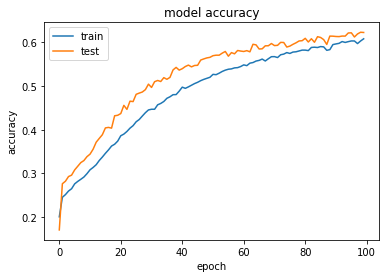

In [21]:
# summarize history for accuracy
plt.plot(grpah_model.history['accuracy'])
plt.plot(grpah_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Epochs vs Loss

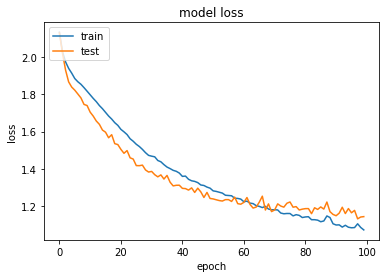

In [22]:
# summarize history for loss
plt.plot(grpah_model.history['loss'])
plt.plot(grpah_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

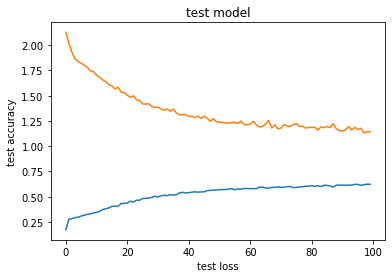

In [23]:
plt.plot(grpah_model.history['val_accuracy'])
plt.plot(grpah_model.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

### Confusion Matrix showing all classes

In [24]:
y_pred=model_CNN1d.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np

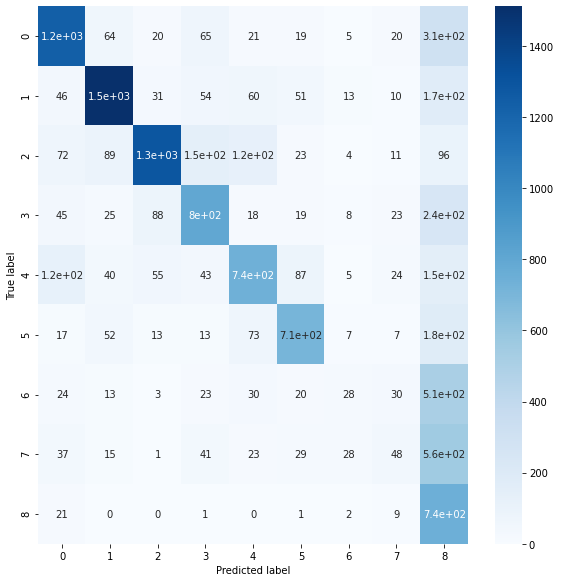

In [25]:
y_test[1]
y_pred[1]
y_test1=np.argmax(y_test, axis=1)
y_pred=np.argmax(y_pred,axis=1)
cmatrix=confusion_matrix(y_test1, y_pred)
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC Curve

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [27]:
# make probability predictions with the model
predictions = model_CNN1d.predict(x_test)
# round predictions 
rounded = [round(x[0]) for x in predictions]
rounded = np.array(rounded)
rounded.shape

(11421,)

In [28]:
# make class predictions with the model
predictions = model_CNN1d.predict_classes(x_test)

In [29]:
temp = label_binarize(predictions,classes = [0,1,2,3,4,5,6,7,8,9] )
temp
temp1 = label_binarize(y_test,classes = [0,1,2,3,4,5,6,7,8,9] )
temp1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [30]:
false_pr = dict()
true_pr = dict()
roc_auc = dict()
for i in range(classes-1):
    false_pr[i], true_pr[i], _ = roc_curve(temp1[:, i], temp[:, i])
    roc_auc[i] = auc(false_pr[i], true_pr[i])

false_pr["micro"], true_pr["micro"], _ = roc_curve(temp1.ravel(), temp.ravel())
roc_auc["micro"] = auc(false_pr["micro"], true_pr["micro"])

In [31]:
classes = classes  -1
lw = 2

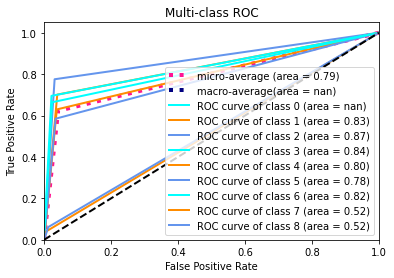

In [32]:
combined_fpr = np.unique(np.concatenate([false_pr[i] for i in range(classes)]))

# Then interpolate all ROC curves at this points
average_tpr = np.zeros_like(combined_fpr)
for i in range(classes):
    average_tpr += interp(combined_fpr, false_pr[i], true_pr[i])

average_tpr /= (classes)

false_pr["macro"] = combined_fpr
true_pr["macro"] = average_tpr
roc_auc["macro"] = auc(false_pr["macro"], true_pr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(false_pr["micro"], true_pr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(false_pr["macro"], true_pr["macro"],
         label='macro-average(area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(classes), colors):
    plt.plot(false_pr[i], true_pr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

In [33]:
cm = cmatrix
cm

array([[1234,   64,   20,   65,   21,   19,    5,   20,  312],
       [  46, 1511,   31,   54,   60,   51,   13,   10,  173],
       [  72,   89, 1290,  147,  124,   23,    4,   11,   96],
       [  45,   25,   88,  799,   18,   19,    8,   23,  244],
       [ 119,   40,   55,   43,  742,   87,    5,   24,  154],
       [  17,   52,   13,   13,   73,  714,    7,    7,  179],
       [  24,   13,    3,   23,   30,   20,   28,   30,  513],
       [  37,   15,    1,   41,   23,   29,   28,   48,  558],
       [  21,    0,    0,    1,    0,    1,    2,    9,  745]])

In [34]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [36]:
print("Recall",np.nanmean(recall))
print("{precision}",np.nanmean(precision))

Recall 0.5676450353908482
{precision} 0.5942509526070409
